In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix,roc_auc_score,precision_recall_curve,roc_curve,average_precision_score

In [2]:
df= pd.read_csv("/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv")

In [ ]:
df.head()

1 step- is 1 hour of time, total 744 steps 30 days  
type-  Cashin, cash_out, debit, payment, transfer  
nameOrig- customer who started the transaction  
oldbalanceOrg- initial balance before transaction  
newbalanceOrg- new balance after transaction  
nameDest- customer who is reciepient of transaction  
oldbalancedest,newbalancedest- there is no information for customers that start with M (Merchants)  
isFraud- label
isFlaggedFraud- flags illegal attempts, to transfer more than 200,000  

In [ ]:
df.describe()

In [ ]:
df.info()
#  6362620 entries

In [ ]:
df["isFraud"].value_counts(normalize=True)*100

In [ ]:
(df["isFraud"]==1).sum()

In [ ]:
df.isnull().sum().max()

# Marking all TRANSFER-CASH_OUT same amount pairs in full dataset (6.3M) before sampling

In [4]:
# 1) Get the 249 mule accounts (overlap)
mule_accounts = set(df.loc[df['type']=='TRANSFER','nameDest']) & set(df.loc[df['type']=='CASH_OUT','nameOrig'])
print("Mule accounts count:", len(mule_accounts))
print("First 10 mule accounts:", list(mule_accounts)[:10])

# 2) Inspect one mule account’s transactions
sample_acct = list(mule_accounts)[0]
print("\nTransactions for sample mule account:", sample_acct)
print(df[(df['nameOrig']==sample_acct) | (df['nameDest']==sample_acct)].head(20))

# 3) Count how many TRANSFERs → CASH_OUTs exist for these mule accounts (ignoring amount)
transfers = df[(df['type']=='TRANSFER') & (df['nameDest'].isin(mule_accounts))]
cashouts  = df[(df['type']=='CASH_OUT') & (df['nameOrig'].isin(mule_accounts))]
print("\nTransfers involving mule accounts:", len(transfers))
print("Cashouts involving mule accounts:", len(cashouts))

# 4) Merge only on account (no amount, no step filter yet)
pairs = pd.merge(
    transfers, cashouts,
    left_on='nameDest', right_on='nameOrig',
    suffixes=('_trans','_cash')
)
print("Pairs columns:", pairs.columns.tolist())
print(pairs.head(3))

print("\nCandidate pairs (account match only, no filters):", len(pairs))
print(pairs[['nameDest','amount_trans','amount_cash','step_trans','step_cash']].head(10))

Mule accounts count: 249
First 10 mule accounts: ['C847929305', 'C576964585', 'C1714931087', 'C1359185569', 'C1290343541', 'C1828559417', 'C1893959923', 'C1168413265', 'C27739138', 'C1534918445']

Transactions for sample mule account: C847929305
         step      type     amount     nameOrig  oldbalanceOrg  \
661377     36  CASH_OUT   52607.30   C847929305           0.00   
1781193   162  CASH_OUT  144826.20   C815357937       60774.00   
2089891   182  CASH_OUT   75987.07   C401392237       19155.25   
2324248   188   CASH_IN   58196.03   C740483907     2959284.83   
2415477   202   CASH_IN  205874.30  C2095236522      202807.00   
2450092   203  CASH_OUT  197538.09   C997166532       10505.00   
2463867   203  TRANSFER  149062.65    C80778108       10152.00   
2631979   209  CASH_OUT  200028.65     C1592924           0.00   
3074634   235  CASH_OUT  117336.00  C1249409292           0.00   
3465046   257  CASH_OUT  385922.95  C1650598601       32799.00   
4681191   331   CASH_IN  182

KeyError: "['nameDest'] not in index"

In [18]:
# 1) Check exact spellings of transaction types
print(df['type'].unique())

# 2) Quick sample of TRANSFER / CASH_OUT rows
print("TRANSFER sample:")
print(df[df['type']=='TRANSFER'][['nameOrig','nameDest','amount','step']].head(5))
print("\nCASH_OUT sample:")
print(df[df['type']=='CASH_OUT'][['nameOrig','nameDest','amount','step']].head(5))
# if the above prints empty for CASH_OUT, try 'CASH_OUT' and re-run.

# 3) Check how many unique IDs are in nameDest (from transfers) and nameOrig (from cash_outs)
set_trans_nameDest = set(df.loc[df['type']=='TRANSFER','nameDest'].unique())
set_cash_nameOrig = set(df.loc[df['type']=='CASH_OUT','nameOrig'].unique())  # try 'CASH_OUT' if needed
print("Transfer unique nameDest:", len(set_trans_nameDest))
print("Cash_out unique nameOrig:", len(set_cash_nameOrig))
print("Intersection size:", len(set_trans_nameDest & set_cash_nameOrig))

# 4) Check for whitespace or non-printable characters (show examples)
sample_names = list(df.loc[df['type']=='TRANSFER','nameDest'].astype(str).head(10))
print("Sample transfer nameDest strings (repr):", [repr(x) for x in sample_names])

# 5) Check amount dtype and sample values
print(df['amount'].head(10))
print("amount unique sample:", df['amount'].unique()[:10])


['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']
TRANSFER sample:
       nameOrig     nameDest     amount  step
2   C1305486145   C553264065     181.00     1
19  C1670993182  C1100439041  215310.30     1
24  C1984094095   C932583850  311685.89     1
58  C1976401987  C1937962514   62610.80     1
78   C283039401  C1330106945   42712.39     1

CASH_OUT sample:
       nameOrig     nameDest     amount  step
3    C840083671    C38997010     181.00     1
15   C905080434   C476402209  229133.94     1
42   C768216420  C1509514333  110414.71     1
47  C1570470538   C824009085   56953.90     1
48   C512549200   C248609774    5346.89     1
Transfer unique nameDest: 237006
Cashout unique nameOrig: 2236357
Intersection size: 249
Sample transfer nameDest strings (repr): ["'C553264065'", "'C1100439041'", "'C932583850'", "'C1937962514'", "'C1330106945'", "'C1761291320'", "'C783286238'", "'C1749186397'", "'C766572210'", "'C392292416'"]
0     9839.64
1     1864.28
2      181.00
3      181.00
4    1166

In [23]:
import numpy as np
import pandas as pd

# 0) ensure you are working on the full df (not the sampled one)
print("Using df shape:", df.shape)

# 1) Normalize string columns (strip and uppercase to remove invisible differences)
df['nameOrig']  = df['nameOrig'].astype(str).str.strip()
df['nameDest']  = df['nameDest'].astype(str).str.strip()
df['type']      = df['type'].astype(str).str.strip().str.upper()   # normalize type to uppercase

# 2) Check type names (re-run if you see 'CASH_OUT' vs 'CASH_OUT')
print("Unique types:", df['type'].unique())

# 3) Create rounded amount to avoid float precision issues (2 decimal places)
df['amount_rnd2'] = df['amount'].round(2)

# 4) Build transfer and cash_out frames with original indices kept
trans_df = df[df['type']=='TRANSFER'][['nameDest','amount_rnd2','step','isFraud']].copy()
trans_df['orig_index_trans'] = trans_df.index

cash_df  = df[df['type'].isin(['CASH_OUT','CASH_OUT'])][['nameOrig','amount_rnd2','step','isFraud']].copy()
cash_df['orig_index_cash'] = cash_df.index

# If cash_df is empty because type naming is different, try printing df['type'].unique() above and adjust .isin

print("Transfers:", len(trans_df), "Cash_outs:", len(cash_df))

# 5) Merge on recipient==origin and rounded amount
pairs = pd.merge(
    trans_df,
    cash_df,
    left_on=['nameDest','amount_rnd2'],
    right_on=['nameOrig','amount_rnd2'],
    how='inner',
    suffixes=('_trans','_cash')
)

print("Candidate pairs (merged):", len(pairs))

# 6) Keep only those where cash_out happens after transfer, optionally allow a small time gap
max_gap = 2   # allow up to 2 time-steps difference (adjust to 0 or 1 if you want stricter)
pairs = pairs[(pairs['step_cash'] >= pairs['step_trans']) & ((pairs['step_cash'] - pairs['step_trans']) <= max_gap)]
print("Pairs after enforcing step gap <= {}: {}".format(max_gap, len(pairs)))

# 7) If still 0, relax max_gap or inspect the first few candidate rows before filtering:
if len(pairs)==0:
    print("No pairs after time-gap filter. Inspecting first 10 merged candidates before filtering (if any):")
    tmp_pairs = pd.merge(
        trans_df, cash_df,
        left_on=['nameDest','amount_rnd2'],
        right_on=['nameOrig','amount_rnd2'],
        how='inner'
    )
    print("Merged candidates (unfiltered):", len(tmp_pairs))
    display(tmp_pairs.head(10))
else:
    # 8) Flag indices back in original df
    idx_trans = pairs['orig_index_trans'].tolist()
    idx_cash  = pairs['orig_index_cash'].tolist()
    pair_idx = list(set(idx_trans + idx_cash))

    df['is_pair_rule'] = 0
    df.loc[pair_idx, 'is_pair_rule'] = 1

    print("Transactions in pairs flagged:", df['is_pair_rule'].sum())
    print("Fraud rows in pairs:", df.loc[df['is_pair_rule']==1,'isFraud'].sum())
    print("Fraction of all fraud explained by rule:",
          df.loc[df['is_pair_rule']==1,'isFraud'].sum() / df['isFraud'].sum())


Using df shape: (6362620, 13)
Unique types: ['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']
Transfers: 532909 Cash_outs: 2237500
Candidate pairs (merged): 0
Pairs after enforcing step gap <= 2: 0
No pairs after time-gap filter. Inspecting first 10 merged candidates before filtering (if any):
Merged candidates (unfiltered): 0


,nameDest,amount_rnd2,step_x,isFraud_x,orig_index_trans,nameOrig,step_y,isFraud_y,orig_index_cash


In [12]:
# 1. Transfer dataframe (recipients)
df_transfer = df[df['type']=='TRANSFER'][['nameDest','amount','step','isFraud']].copy()
df_transfer['orig_index_trans'] = df_transfer.index

# 2. Cash-out dataframe (origins)
df_cashout = df[df['type']=='CASH_OUT'][['nameOrig','amount','step','isFraud']].copy()
df_cashout['orig_index_cash'] = df_cashout.index

# 3. Merge on account IDs only (not amount)
pairs = pd.merge(
    df_transfer, df_cashout,
    left_on='nameDest',
    right_on='nameOrig',
    how='inner',
    suffixes=('_trans','_cash')
)

print("Candidate pairs (account match only):", len(pairs))

# 4. Keep only valid time order (cash-out after transfer)
pairs = pairs[pairs['step_cash'] >= pairs['step_trans']]

# 5. Optionally enforce approx equal amounts (within 1 unit tolerance)
pairs = pairs[abs(pairs['amount_trans'] - pairs['amount_cash']) < 1e-2]  # allow cent difference

print("Candidate fraud-like pairs:", len(pairs))
print(pairs[['nameDest','nameOrig',
             'amount_trans','amount_cash',
             'step_trans','step_cash',
             'isFraud_trans','isFraud_cash']].head(10))

# 6. Collect indices back
pair_idx = list(set(pairs['orig_index_trans']).union(set(pairs['orig_index_cash'])))
df['is_pair_rule'] = 0
df.loc[pair_idx, 'is_pair_rule'] = 1

print("Transactions in pairs:", df['is_pair_rule'].sum())
print("Fraud in these pairs:", df.loc[df['is_pair_rule']==1,'isFraud'].sum())
print("Fraction of fraud explained by rule:",
      df.loc[df['is_pair_rule']==1,'isFraud'].sum() / df['isFraud'].sum())


Candidate pairs (account match only): 572
Candidate fraud-like pairs: 0
Empty DataFrame
Columns: [nameDest, nameOrig, amount_trans, amount_cash, step_trans, step_cash, isFraud_trans, isFraud_cash]
Index: []
Transactions in pairs: 0
Fraud in these pairs: 0
Fraction of fraud explained by rule: 0.0


In [22]:
print("Full dataset shape:",df.shape)
print("Fraud Count:",df['isFraud'].sum())
# 1. Split into TRANSFER and CASH_OUT

df_transfer= df[df['type']=='TRANSFER'][['nameDest','amount','step','isFraud']]
df_transfer['orig_index'] = df_transfer.index

df_cashout= df[df['type']=='CASH_OUT'][['nameOrig','amount','step','isFraud']]
df_cashout['orig_index'] = df_cashout.index

# 2. Merge on (nameOrig,amount) -> potential pairs
pairs= pd.merge(
    df_transfer,df_cashout,
    left_on= ['nameDest','amount'],
    right_on= ['nameOrig','amount'],
    how="inner",
    suffixes=('_trans','_cash')
)

# 3. Keep only valid pairs: CASH_OUT must happen after TRANSFER
pairs= pairs[pairs['step_cash'] >= pairs['step_trans']]
print("Total candidate pairs",len(pairs))

# 4. Collect original indices of both TRANSFER and CASH_OUT involved
pair_idx = list(set(pairs['orig_index_trans']).union(set(pairs['orig_index_cash'])))

# 5. Flag Back to Full Dataset
df['is_pair_rule']=0
df.loc[pair_idx, 'is_pair_rule']=1

print("Transactions in pairs:", df['is_pair_rule'].sum())
print("Fraud in these pairs:", df.loc[df['is_pair_rule']==1,'isFraud'].sum())
print("Fraction of all fraud explained by rule:",
      df.loc[df['is_pair_rule']==1,'isFraud'].sum()/df['isFraud'].sum())

Full dataset shape: (6362620, 13)
Fraud Count: 8213
Total candidate pairs 0
Transactions in pairs: 0
Fraud in these pairs: 0
Fraction of all fraud explained by rule: 0.0


In [4]:
fraud_df= df[df["isFraud"]==1]
nonfraud_df= df[df["isFraud"]==0]
# sample 10x non-fraud cases
nonfraud_sample= nonfraud_df.sample(n=len(fraud_df)*9,random_state=42)
df= pd.concat([fraud_df,nonfraud_sample]).sample(frac=1,random_state=42).reset_index(drop=True)
# .sample() selects rows randomly from dataframe not sequential/series
# after concat indexes of both dfs remain- thus duplicate indexes
# frac=1 means take 100% of rows but shuffled
# reset_index(drop=True) bcz indexes are duplicates and random, it creates a fresh clean index
print("Original dataset shape:", df.shape)
print("Fraud cases:", len(fraud_df))
print("Sampled dataset shape:", df.shape)
print("Fraud % in new dataset:", df['isFraud'].mean() * 100)

Original dataset shape: (82130, 11)
Fraud cases: 8213
Sampled dataset shape: (82130, 11)
Fraud % in new dataset: 10.0


drop  
isFlaggedFraud, threshold based, useless  
newbalanceOrig & newbalanceDest- post transaction info, leakage
drop nameOrig & nameDest- customer Ids, not generalizable
keep step,type,amount,oldbalanceOrg,oldbalanceDest,isFraud

In [12]:
df= pd.read_csv("/kaggle/input/transactions-fraud-data/paysim_withoutdrop.csv")

In [ ]:
# df_small= df.drop(columns= ['isFlaggedFraud', 'nameOrig', 'nameDest', 
#                                   'newbalanceOrig', 'newbalanceDest'])
# df._small.to_csv("/kaggle/working/paysim_small.csv",index=False)
# df_small.head()

In [14]:
df_small= pd.read_csv("/kaggle/input/transactions-fraud-data/paysim_small.csv")

In [19]:
# sns.set_style("whitegrid")
# sns.reset_defaults()
# for reversing sns.set_style(None) / sns.reset_defaults()
plt.rcParams["figure.figsize"] = (10,5)
# plt.rcParams- global config dictionary for matplotlib
# for reseting use plt.rcParams["figure.figsize"]= plt.rcParamsDefault["figure.figsize"]

In [20]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Transaction type counts split by isFraud

Proportion (%) of fraud within each type:
 type
TRANSFER    40.10
CASH_OUT    13.68
CASH_IN      0.00
DEBIT        0.00
PAYMENT      0.00
Name: 1, dtype: float64


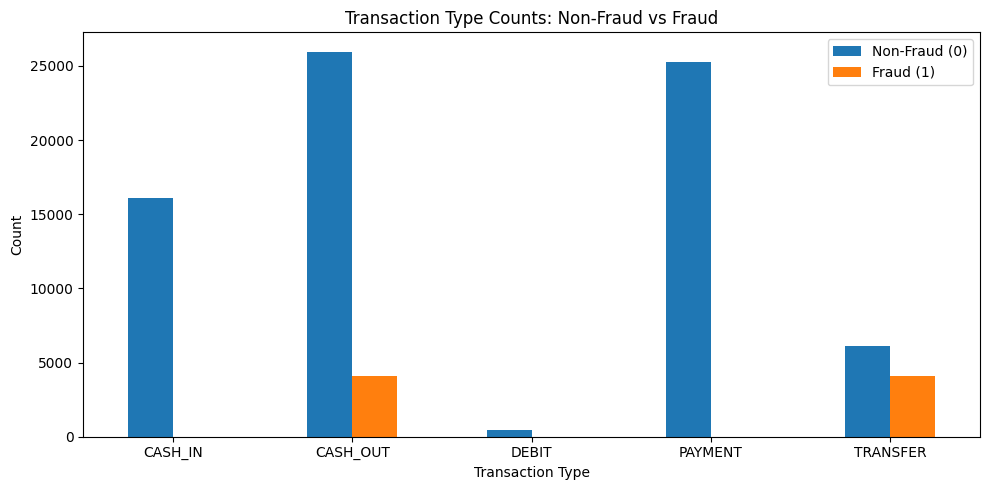

In [21]:
# counts of types by fraud flag
type_counts= df_small.groupby(['type','isFraud']).size().unstack(fill_value=0)
# cash_out fraud, cash_out nonfraud : 2 such rows for every type
# size method count no of rows in each group
# moved second grouping level from rows->columns : easier for plotting
# fill_value=0 means if any combination doesn't exist eg no frauds in CASH_IN fills with 0 instead of NaN

type_counts.plot(kind="bar", stacked=False)
plt.title("Transaction Type Counts: Non-Fraud vs Fraud")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.xticks(rotation=0) # keeps label horizontal
plt.legend(["Non-Fraud (0)","Fraud (1)"])
plt.tight_layout() # adjusts spacing of plot automatically 
# proportions
prop= (type_counts.div(type_counts.sum(axis=1),axis=0)*100).round(2)
# first add fraud + nonfrauds across columns for each type, divides each row by row's total
print("Proportion (%) of fraud within each type:\n",prop[1].sort_values(ascending=False))
plt.show()

# Log(amount) distribution (fraud vs non-fraud)

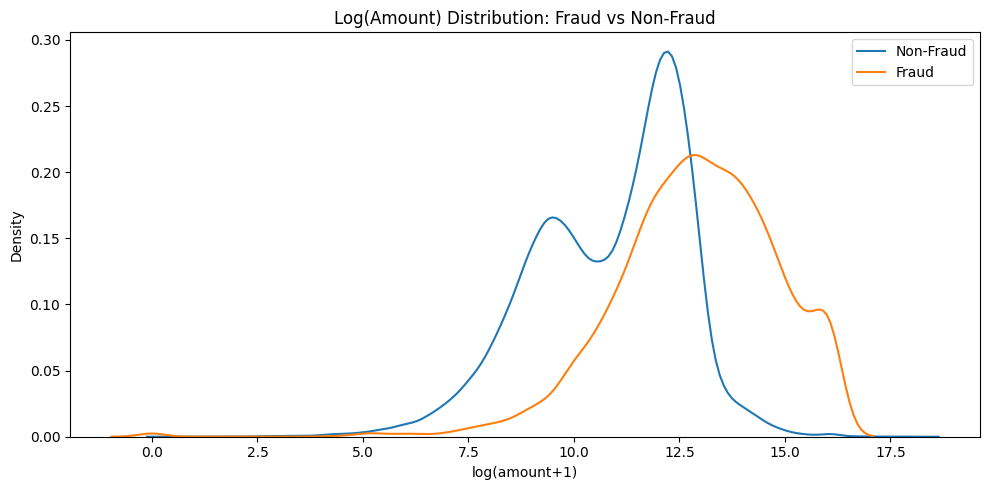

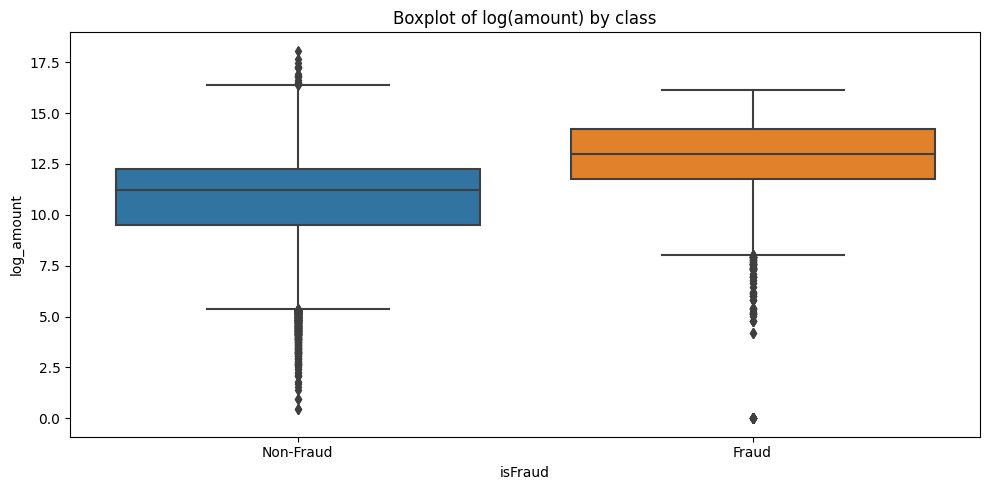

In [22]:
df_small['log_amount']= np.log1p(df_small['amount'])
# kde/histogram overlay
sns.kdeplot(df_small.loc[df_small['isFraud']==0,'log_amount'],label='Non-Fraud',bw_adjust=1.0)
sns.kdeplot(df_small.loc[df_small['isFraud']==1,'log_amount'],label='Fraud',bw_adjust=1.0)
plt.xlabel("log(amount+1)")
plt.title("Log(Amount) Distribution: Fraud vs Non-Fraud")
plt.legend()
plt.tight_layout()
plt.show()

# Optionally plot boxplots to show median/spread=
sns.boxplot(x='isFraud',y='log_amount',data=df_small)
plt.xticks([0,1],['Non-Fraud','Fraud'])
plt.title("Boxplot of log(amount) by class")
plt.tight_layout()
plt.show()

In [ ]:
print((df_small['amount']<0).sum())
print(df_small['amount'].describe())
print(np.isinf(df_small['log_amount']).sum())

# Time trend - fraud count per day & hour

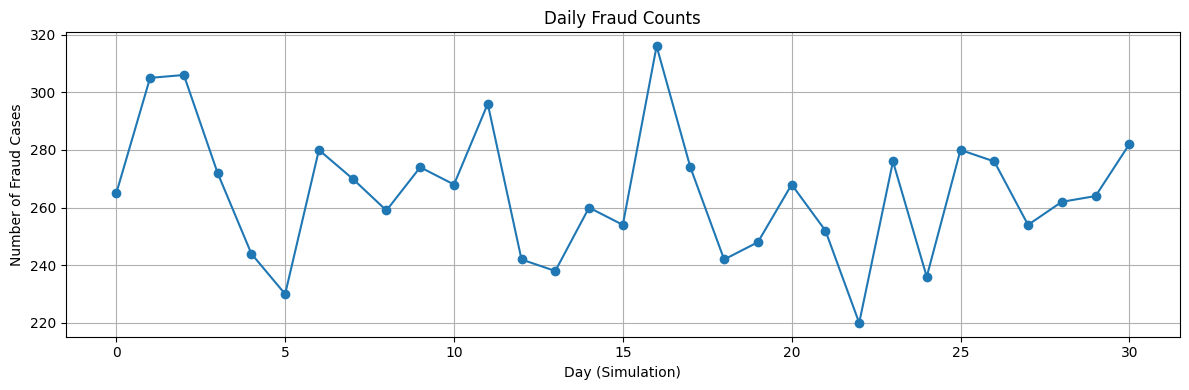

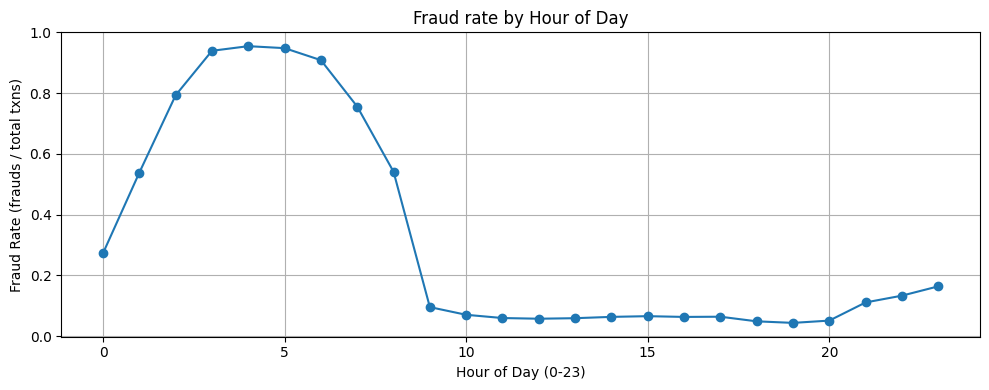

In [23]:
# create day and hour derived features from step 
df_small["day"]= df_small["step"]//24
df_small['hour']= df_small["step"]%24
# Fraud counts per day
daily= df_small.groupby('day')['isFraud'].sum()
# groupby('day')- groups transactions belonging to same day, selects isFraud column
plt.figure(figsize=(12,4))
daily.plot(kind='line', marker='o')
plt.title('Daily Fraud Counts')
plt.xlabel("Day (Simulation)")
plt.ylabel("Number of Fraud Cases")
plt.grid(True)
plt.tight_layout()
# plt.show()

# Fraud rate by hour-of-day (normalized)
hourly= df_small.groupby('hour').agg(total=('isFraud','count'),frauds=('isFraud','sum'))
# .agg(aggregate multiple metrics in one go)
# total=('isFraud','count') equivalent to groupby().size() counts how many transactions in that hour
# summing isFraud is 0/1 summing it gives no. of fraud transactions in that hour
hourly['fraud_rate']= hourly['frauds']/hourly['total']
# fraud proportion per hour
plt.figure(figsize=(10,4))
plt.plot(hourly.index,hourly['fraud_rate'],marker='o')
plt.title("Fraud rate by Hour of Day")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Fraud Rate (frauds / total txns)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
df_small.head()

,step,type,amount,oldbalanceOrg,oldbalanceDest,isFraud,log_amount,day,hour
0,262,TRANSFER,201281.36,201281.36,0.00,1,12.212464,10,22
1,592,CASH_OUT,305609.75,35114.00,0.00,0,12.630068,24,16
2,203,CASH_IN,69481.15,6455577.40,78079.01,0,11.148825,8,11
3,235,CASH_OUT,147616.00,18255.00,164249.28,0,11.902376,9,19
4,238,CASH_OUT,146520.53,0.00,172855.61,0,11.894928,9,22


In [13]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,262,TRANSFER,201281.36,C1271087457,201281.36,0.00,C1017401472,0.00,0.00,1,0
1,592,CASH_OUT,305609.75,C110437570,35114.00,0.00,C1501890968,0.00,305609.75,0,0
2,203,CASH_IN,69481.15,C252479819,6455577.40,6525058.55,C371965331,78079.01,8597.86,0,0
3,235,CASH_OUT,147616.00,C1560809876,18255.00,0.00,C66026090,164249.28,311865.29,0,0
4,238,CASH_OUT,146520.53,C437474476,0.00,0.00,C322943374,172855.61,319376.15,0,0


# Detecting Transfer -> Cash_out same amount immediate pairs and quantify

In [30]:
# sort by origin id + step to ensure order per account
df= df.sort_values(['nameOrig','step']).reset_index(drop=True)
# Find immediate pairs: a TRANSFER followed by a CASH_OUT by same origin/destination and same amount
pairs_idx= []
for i in range(len(df)-1):
    row= df.iloc[i]
    nxt= df.iloc[i+1]
    if(row['type']== 'TRANSFER' and nxt['type']=='CASH_OUT'):
        # check same amount and same origin
        if(row['amount']==nxt['amount'] and row['nameOrig']==nxt['nameOrig']):
            pairs_idx.append(i)
            pairs_idx.append(i+1)

pairs_idx= sorted(set(pairs_idx))
len_pairs=  len(pairs_idx)
print("Number of transactions involved in immediate transfer->cashout pairs:",len_pairs)


Number of transactions involved in immediate transfer->cashout pairs: 0


In [29]:
df.head(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,262,TRANSFER,201281.36,C1271087457,201281.36,0.00,C1017401472,0.00,0.00,1,0
1,592,CASH_OUT,305609.75,C110437570,35114.00,0.00,C1501890968,0.00,305609.75,0,0
2,203,CASH_IN,69481.15,C252479819,6455577.40,6525058.55,C371965331,78079.01,8597.86,0,0
3,235,CASH_OUT,147616.00,C1560809876,18255.00,0.00,C66026090,164249.28,311865.29,0,0
4,238,CASH_OUT,146520.53,C437474476,0.00,0.00,C322943374,172855.61,319376.15,0,0
5,44,CASH_IN,234882.48,C755818933,1015180.07,1250062.55,C305257854,932364.60,697482.12,0,0
6,179,PAYMENT,3103.95,C1185153641,118583.00,115479.05,M110198599,0.00,0.00,0,0
7,397,CASH_IN,93883.86,C1854614670,2767812.39,2861696.26,C1532237098,155748.45,61864.59,0,0
8,186,CASH_OUT,15468.13,C2031520657,40634.00,25165.87,C791994986,57682.88,73151.01,0,0
9,304,PAYMENT,4539.59,C617864152,49830.00,45290.41,M1102319361,0.00,0.00,0,0
